# A Simple Example of Solving PDE with DL

In [15]:
import torch
import numpy as np
from tqdm import trange
from torch import nn, autograd, optim

%matplotlib notebook 
import matplotlib.pyplot as plt
from matplotlib import animation

In [29]:
class Anime:
    """
    Args:
        data        two-tuple: (x, y)
                    x is a discretization along X axis
                    y[t] is the target values at x points
                    at time t
    """
    def __init__(self, fig, data, label=None):
        self.line, = plt.plot([], [], lw=2, label=label)
        self.anime = animation.FuncAnimation(
            fig, self.update, init_func=self.init, 
            frames=200, interval=20, repeat=False, blit=True)
    # << `repeat=True` leads to the divergence of graphs if there are more than 2
        
        self.data = data

    def init(self):
        self.line.set_data([], [])

    def update(self, t):
        x, y = self.data
        self.line.set_data(x, y[t])

In [17]:
# Exact solution of the problem {du/dt + a du/dx = 0, u(0, x) = gauss(x)}
def dome(x, t=0, a=.5, alpha=200):
    if isinstance(t, torch.Tensor):
        t = t[:, None]
    
    return torch.exp(-alpha * ((x-.25) - a*t)**2)

In [18]:
def running_mean(signal, ww=80):
    """
    Args:
    -----
        ww        window width
    """
    return np.convolve(signal, np.ones(ww)/ww, mode='valid')

In [19]:
class HGAESolver(nn.Module):
    """
    Homogeneous Advection Equation Solver
    -------------------------------------
    du/dt + a du/dx = 0
    u(0, x) = gauss(x)
    -------------------------------------
    Type of PDE does not effect the network
    architecture, only the training pipeline
    -------------------------------------
    Args:
        a                 wave velocity
        l                 length of calculation area along x axis
                          (starting from 0)
        T                 length of calculation area along t axis
                          (starting from 0)
                          
                          Thus, (0, l) x (0, T) is the training domain
                          
        hyppar            loss hyperparameter defining balance
                          between the approximation of PDE and 
                          initial condition
    """
    def __init__(self, a=.5, l=1., T=10., hyppar=1.):
        super().__init__()
        self.a = a
        self.l = l
        self.T = T
        self.hyppar = hyppar
        
        self.main = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True), 
            nn.Linear(128, 1)
        )
        self.device = next(self.parameters()).device
        
    def forward(self, x):
        return self.main(x)
    
    def sampleBatch(self, N=64, M=32):
        """
        N - number of points to sample in the domain (x, t)
        M - __..__..__..__..__ to sample on the x axis
        """
        x = torch.zeros(M, 2, device=self.device)
        x[:, 1] = self.l * torch.rand(M, device=self.device)
        
        tx = torch.rand(N, 2, device=self.device)
        tx[:, 0].mul_(self.T)
        tx[:, 1].mul_(self.l)
        
        return x, tx

    def computeLoss(self, y_domain, y_border, x_domain, x_border):
        jacobian = autograd.grad(
            outputs=y_domain, inputs=x_domain,
            grad_outputs=torch.ones_like(y_domain),
            create_graph=True)[0]
        du_t, du_x = torch.unbind(jacobian, 1)
        
        return torch.norm(du_t + self.a * du_x) + self.hyppar * torch.norm(
            y_border.view(-1) - dome(x_border[:, 1], a=self.a)) 

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_batches = int(3e3)
solver = HGAESolver().to(device)
optimizer = optim.Adam(solver.parameters())

In [21]:
%%time
loss_history = []
try:
    for _ in trange(num_batches, desc='Training'):
        optimizer.zero_grad()

        x, tx = solver.sampleBatch()
        tx.requires_grad_(True)
        y_b = solver(x)
        y_d = solver(tx)

        loss = solver.computeLoss(y_d, y_b, tx, x)
        loss_history.append(loss.item())
        loss.backward()

        optimizer.step()
        
except KeyboardInterrupt:
    pass

Training: 100%|██████████| 3000/3000 [00:55<00:00, 54.24it/s]

CPU times: user 6min 15s, sys: 6.84 s, total: 6min 22s
Wall time: 55.3 s


<IPython.core.display.Javascript object>


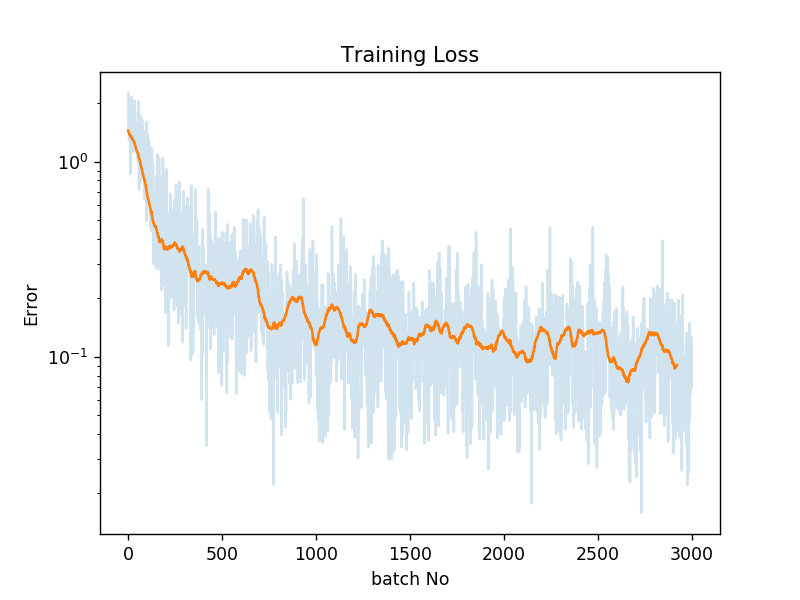

In [22]:
plt.figure()
plt.plot(loss_history, alpha=.2)
plt.plot(running_mean(loss_history))
plt.yscale('log')
plt.title('Training Loss')
plt.ylabel('Error')
plt.xlabel('batch No');

## Initial Condition approximation

<IPython.core.display.Javascript object>


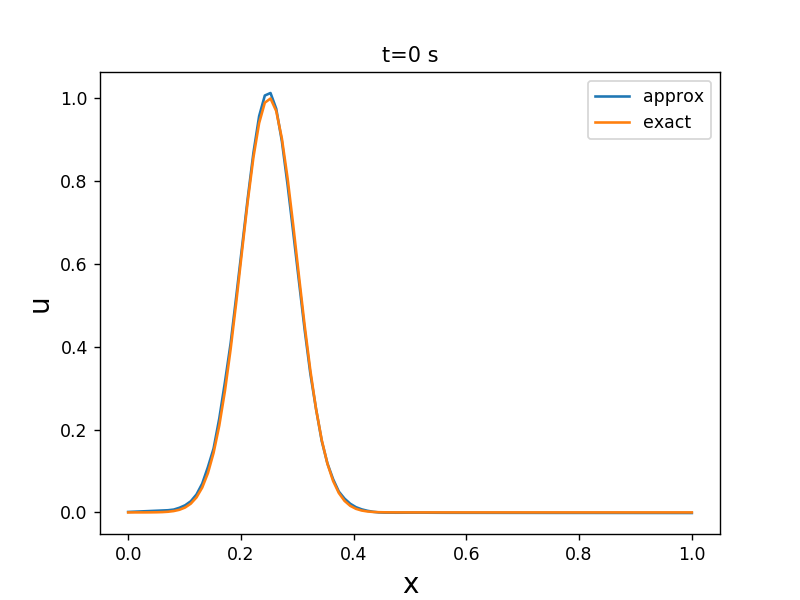

In [27]:
x = torch.linspace(0, 1)
tx = torch.stack((torch.zeros_like(x), x), 1)

y = solver(tx).detach().cpu().numpy()
y_true = dome(x).numpy()
x = x.numpy()

plt.figure()
plt.plot(x, y, label='approx')
plt.plot(x, y_true, label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title('t=0 s')
plt.legend();

## Approximation at time `t`

<IPython.core.display.Javascript object>


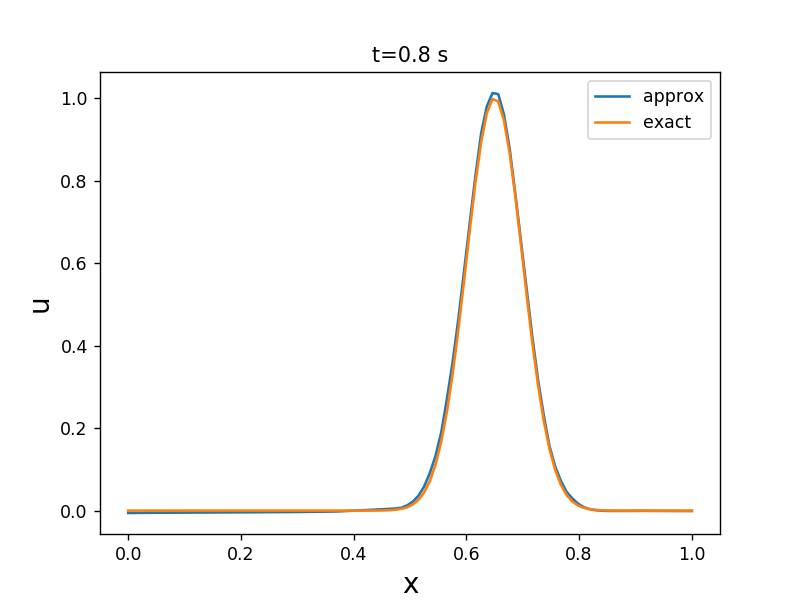

In [24]:
t = .8 
x = torch.linspace(0, 1)
tx = x.new(len(x), 2)
tx[:, 0].fill_(t)
tx[:, 1] = x

y = solver(tx).detach().cpu().numpy()
y_true = dome(x, t).numpy()
x = x.numpy()

plt.figure()
plt.plot(x, y, label='approx')
plt.plot(x, y_true, label='exact')
plt.xlabel('x', size=16)
plt.ylabel('u', size=16)
plt.title(f't={t} s')
plt.legend();

## Run cell to start animating
if there is only one graph, re-run the cell

<IPython.core.display.Javascript object>


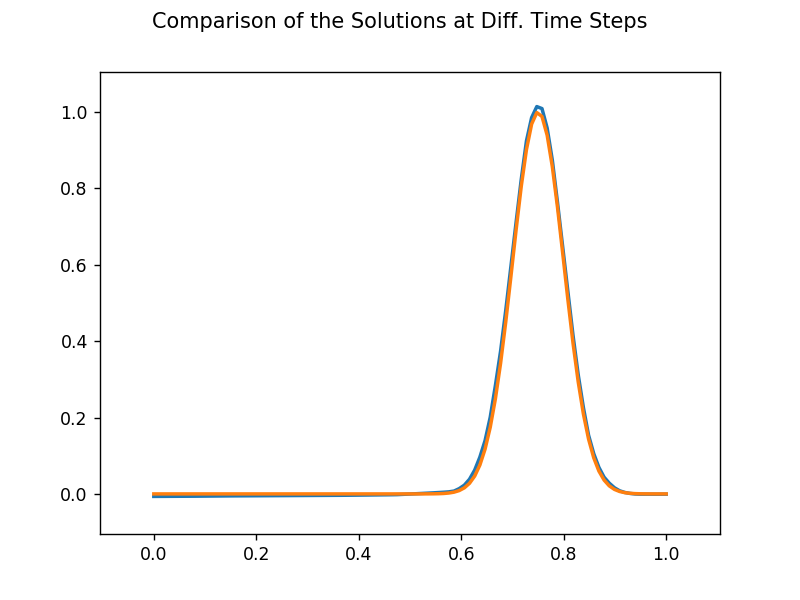

In [62]:
z = torch.linspace(0, 1)
t = torch.linspace(0, 1)
y = dome(z, t)
true_data = (z.numpy(), y.numpy())

t = t.view(-1, 1)
t = t.expand(-1, len(z))
x = z.view(1, -1)
x = x.expand(x.size(1), -1)
tx = torch.stack((t, x), -1)
y = solver(tx).view(len(tx), -1).detach().cpu()
appr_data = (z.numpy(), y.numpy())

fig = plt.figure()
fig.suptitle('Comparison of the Solutions at Diff. Time Steps')
Anime(fig, appr_data)
Anime(fig, true_data);